# What's in a Game? Analyzing Trends in Popular Board Games
### Robert Choi, Andrew Walter-McNeill

## Introduction
When designing a product, predictive classification models can be used to identify what characteristics separate previously successful iterations of the product from less successful iterations. In some cases, the predictive power of these models may be strong enough to warrant incorporating their feedback into the design process. Board game design is an industry in the midst of a renaissance, with sales numbers and the variety of games in the market increasing year after year. Given that these games incorporate a variety of mechanics, genres, and intellectual properties, we were interested in the possibility that certain combinations of these attributes could predispose a game to critical and commercial success. Thankfully, the advent of BoardGameGeek.com's user-maintained database of board games has made such analyses possible. In this report, we will analyze the results of a predictive classification of a game’s quality based on its mechanics, complexity, and playtime. Additionally, we will compare the predictive abilities of decision trees and artificial neural networks when applied to this dataset using a variety of parameters. Read below for a description of our data, followed by an analysis of our decision tree results.  Continue reading for methodology and comparison of our models, along with the Python code used to generate these models. (Click the “Show Code” button in the top left-hand corner to reveal code.)  It should be noted that code used to create our models will run upon opening this notebook; the models and their results displayed below can and will be slightly different than the static results discussed in our analyses.

## Our Data

The dataset that we examined is a record of the BoardGameGeek.com “Board Game Rank” list compiled in March 2017. The list comprises 90,444 board games, about 5,000 of which are sufficiently well-known to be assigned a rating by the website’s hobbyist community—our dataset is a list of these 5,000 games. Each entry in the list includes the game’s name, publisher, author, date of publication, and “at-a-glance” information about the game’s content, such as its genre, mechanics, average play length, and degree of complexity. Our dataset can be used to investigate whether or not board games possessing particular qualities tend to be rated more highly by the website’s users, and it is remarkably robust in that it is vast, possesses no missing entries, and has perfect internal consistency (e.g. the mechanics classifications are assigned from a pre-made list, rather than assigned ad hoc). A full list of the attributes from the data that were considered by our learners is as follows:
##### min_players 
The minimum number of players required to play a game. Typically 1-12, strictly integers. In our experience, 2-4 player games tend to rank most highly.
##### max_players 
The maximum number of players allowed to play a game. Typically 2-12, strictly integers.
##### avg_time
The average number of minutes required to complete a game. Typically 15-240, strictly integers.
##### min_time
If, on a game's box, a range of times is printed for game length, then this attribute is the low end of that range. Typically 15-180, strictly integers.
##### max_time
If, on a game's box, a range of times is printed for game length, then this attribute is the high end of the range. Typically 30-240, strictly integers.
##### age
The guideline age printed on a game's box that recommends the minimum age of a player that can be expected to enjoy play. Typically 8-15, strictly integers.
##### mechanic
A list of categorical values describing the sorts of game mechanicsthat are included in a game's play. Examples include, "Trading", "Action Point Allowance System", "Co-operative Play", etc.
##### weight
A decimal value on a 5-point scale indicating how complex a game is, based on a number of factors, such as length of the game, length of time it takes to learn the game, complexity of the rule book, simpicity of design, length of time spent planning turn actions, and the amount of luck involved in play. Values range from 1-5, where 1 is "light" and 5 is "heavy".
##### geek_rating
The average of all user submitted ratings for a game with Bayesian Averaging. That is, the average, with additional dummy votes factored in. The effect of Bayesian Averaging is to favor games that have received many user votes over games with fewer user votes; generally, a game's rating will become more accurate as more votes accrue. This is our main class attribute, used to represent a game’s overall quality. Although we will use this attribute to approximate a game's quality, it is worth noting that game quality is a subjective measure, and determining quality by a vote is an imperfect method. For one thing, the Board Game Geek community is a small subset of the broader, board-game-playing public, with a particular set of preferences and priorities. Furthermore, as a result of the Bayesian Averaging, games with a larger player base are able to earn higher scores than games with a smaller audience, as the website's users outweigh the effect of the dummy votes. Possible ratings are from 1-10, but, in practice, values range from 5-9. 

### Preprocessing
The raw dataset has two main problems with it: it contains many categorical attributes, and its class attribute is continuous. There were no missing values. In order to deal with the first issue, we limited the scope of this project to the categorical attribute we felt contained data most relevant to our class attribute (mechanic) and turned it into 52 binary attributes using a variation on one-hot encoding. We then removed the other categorical attributes. To address the second issue, we turned the continuous class attribute, geek_rating, into five quantiles; quantile 0 is populated by the 20% of games with the lowest geek_ratings, quantile 4 is populated by the 20% of games with the highest geek_ratings, etc. Our classification models will attempt to assign a game to one of these five quantiles. This preprocessing left us with 4999 examples, 61 attributes, and one class attribute.

In [7]:
from sklearn import tree                               # to do DTs
from sklearn.datasets import fetch_mldata              # to import data
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier       # MLP: multi-layer perceptron
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import scipy.stats as stats
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd

#in order to directly edit individual cells in a pandas dataframe, this command
#must be issued
pd.options.mode.chained_assignment = None

url = 'https://raw.githubusercontent.com/HumbleBob/BoardGameData/master/original_data.csv'

#genfromtxt reads data into a ndarray, chose this because loadtxt was not 
#working. Forces type string for each element so that all data can be 
#interpereted (specifying none defaults to ASCII byte codes because of the
#strange encoding of the file). Selects important columns

def transformData(raw_data):

    cols = raw_data[0]
    numpy_data = raw_data[1:]


    #CREATES DATAFRAME
    #transforms ndarray into pandas dataframe with headers specified by the first
    #row
    data = pd.DataFrame(data=numpy_data, columns=cols)
    #specifies which attributes should be numeric (as they were all read in as str)
    numeric_columns = ['min_players', 'max_players', 'avg_time', 'min_time', 
                       'max_time', 'geek_rating', 'num_votes', 'age', 'weight']
    #translates specified columns into floats
    data[numeric_columns] = data[numeric_columns].apply(pd.to_numeric)

    #creates quantiles for class attribute
    geek_quantiles = pd.qcut(data['geek_rating'], 5, labels=False)
    data['geek_quantiles'] = geek_quantiles


    #PROCESSES CATEGORICAL ATTRIBUTE
    #first creates empty list to store all categories
    mechanics = []
    #iterates over all attribute values (currently in str form)
    for string_mechs in data['mechanic']:
        #turns str into list of mechanics (find/replaced commas w '*' in excel)
        list_mechs = string_mechs.split('*')
        #gets rid of superfluous spaces and adds mechanic to master list if not
        #already there
        for mech in list_mechs:
            if mech[0] == ' ':
                clean_mech = mech[1:]
                if clean_mech not in mechanics:
                    mechanics.append(clean_mech)
            elif mech not in mechanics:
                mechanics.append(mech)

    #creates new attribute to store each example's mechanics in list form
    data['mechanic_list'] = 0

    #iterates over index of DataFrame
    for index in range(4999):
        #gets rid of superfluous spaces again
        list_mechs = []
        dirty_mechs = data['mechanic'][index].split('*')
        for mech in dirty_mechs:
            if mech[0] == ' ':
                clean_mech = mech[1:]
                list_mechs.append(clean_mech)
            else: 
                list_mechs.append(mech)
        #for each example, defines newly created 'mechanic list' attribute to be
        #a list of its mechanics
        data['mechanic_list'][index] = list_mechs

    #creates 43 new binary attributes, one for each mechanic
    for mechanic in mechanics:
        data[mechanic] = 0

    #defines each binary appropriately: if the attribute appears in the an example's
    #list of mechanics, defined as 1. Otherwise, 0.
    for index in range(4999):
        for mechanic in mechanics:
            if mechanic in data['mechanic_list'][index]:
                data[mechanic][index] = 1

    #removes unneccessary attributes
    del data['mechanic_list']
    del data['mechanic']
    del data['geek_rating']
    del data['num_votes']
    
    #data = data.iloc[:,1:]
    
    #removes the headers from the rest of the data
    headers = data.iloc[0,:]
    #str_data = data.iloc[1:,:]
    #turns the data from floats into strings
    data = data.astype(float)
    #separates the data from the class attributes
    X = data.iloc[:,np.arange(len(headers)) != 7]
    y = data.iloc[:,7]

    return X, y

raw_data = np.genfromtxt(url, delimiter = ',', dtype=str, 
                        usecols=(3,4,5,6,7,10,11,13,14,17))
X, y = transformData(raw_data)


def confusionMatrix(X, y, learning, splitSize=.2, lbls=None):
    '''Create a confusion matrix and report the matrix and the score
    for one training/test split, given X, y, and a learning model as 
    an input. Allow the size of the split to be given as a parameter as well.
    '''
    # Make one test training split
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y,
                                                    test_size=splitSize,
                                                    random_state=10)
    model = learning.fit(Xtrain, ytrain)
    y_model = model.predict(Xtest)
    
    score = accuracy_score(ytest, y_model)
    # if specific labels are specified, implement those labels in the
    # creation of the confusion matrix; otherwise, don't bother.
    if(lbls==None):
        mat = confusion_matrix(ytest, y_model)
    else:
        mat = confusion_matrix(ytest,
                               y_model,
                               labels=lbls)
    print("Score and Confusion Matrix to illustrate problem complexity")
    print("Score: ", score)
    print("Confusion Matrix:\n", mat)
    print()

def fiveFoldCVs(X, y, models):
    '''Performs five five fold cross validations given X, y, and a 
    learning model
    '''
    cvs = []
    
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    
    # For each model passed to the function, perform a 5foldcv and
    # add it to the array to be returned
    for i in range(len(models)):
        score = cross_val_score(models[i], X, y, cv=cv)
        cvs.append(score)
    return cvs

def getPValues(cvs):
    '''Get the p-values for each pair of models, having been passed the 
    cv results
    '''
    # Basically, this offset variable and for loops exist so that every pair
    # of models will have its p-value computed with no repeats
    offset = 0
    for i in range(len(cvs)):
        for j in range(offset, len(cvs)):
            if (i != j):
                # p-values are computed and printed here
                pair = stats.ttest_rel(cvs[i], cvs[j])
                reportStr = "The p-value for " + str(i+1) + "," + str(j+1) + " is " + str(pair[1]) + "\n"
                print(reportStr)
        offset += 1

def getAverages(a):
    '''get the averages of the input, an array of arrays (result of 
    cross validations)
    '''
    result = []
    for i in a:
        result.append(i.mean())
    # return an array of averages corresponding to each array in the input
    return result

def getIntervals(a):
    '''get the confidence intervals for an array of arrays 
    (result of cross validations)
    '''
    result = []
    # set this mysterious value
    z_critical = stats.norm.ppf(q = 0.975)
    # get the averages to work with
    means = getAverages(a)

    # for each array
    for i in range(len(a)):
        # determine the standard deviation
        standard_deviation = a[i].std()
        # to calculate the margin of error
        margin_error = (z_critical * standard_deviation) / (math.sqrt(len(a[i])))
        
        # so as to calculate the confidence interval and add it to the result
        result.append([means[i] - margin_error, means[i] + margin_error])
    return result

def cIPlot(data, ymin=0.3):
    '''Create a confidence interval graph and save it as a file. The
    results of the cross validations are passed as a parameter, as is
    the name of the file to be saved.
    '''
    # Get the averages and confidence intervals for the graph
    sample_means = getAverages(data)
    intervals = getIntervals(data)

    # Set size
    plt.figure(figsize=(9,9))

    xvals = np.arange(5, 30, 5) # This is important given the size of the data
                                # somehow.
    yerrors = [(top-bot)/2 for top,bot in intervals]

    plt.errorbar(x=xvals,
                 y=sample_means,
                 yerr=yerrors,
                 fmt='D')

    # Standardize the graph scale
    plt.axis(xmin=0,xmax=30,ymin=ymin,ymax=1.05)
    # Apply labels
    labels = ["v1", "v2", "v3", "v4", "v5"]
    plt.xticks(xvals,labels)

    plt.show()


## Discussion of Decision Tree Results
![title](https://raw.githubusercontent.com/HumbleBob/BoardGameData/master/Figure1.png)

The precise classification accuracy of all of the decision trees created in this project hovered slightly above 25%. While 25% accuracy can hardly be called reliable, this measure presents a slightly pessimistic evaluation of the trees’ performance.  Because the geek_rating class attribute is an ordinal, rather than a nominal value, classification techniques such as decision trees tend to suffer because they cannot take into account the relations between class values.  To illustrate, it may be considered better for a classifier to mistakenly place a game from the 5th quantile into the 4th quantile rather than the 1st quantile, but classifiers are typically not able to draw this connection.  Given that this is the case, it is encouraging that the confusion matrix for our decision trees show that classifications are more concentrated closest to the matrix’s diagonal line, indicating that games are likely to be classified into a quantile at least close to the one in which they belong.  The decision tree with the highest classification accuracy was tree v5, pictured above, which included a prepruning parameter limiting the number of its leaves to 50.  We will parse the branches of this tree for potential trends. Considering the difficulty posed by this ordinal classification task, we will sometimes group the quantiles together, the top two quantiles to represent “good” games, and the bottom three quantiles to represent mediocre or lacking games. This turns the classification task into a binary one, which allows us a foundation for speaking about the observed trends.
![title](https://raw.githubusercontent.com/HumbleBob/BoardGameData/master/Figure2.png)

The first split separates the 558 games that have a “Hex-and-Counter” mechanic from those that don’t. Games that have a “Hex-and-Counter” mechanic belong predominantly to the lower quantiles of geek_rating: 60% belong to the bottom two quantiles, and 83% belong to the bottom three quantiles. What can explain this broad trend in reception? The “Hex-and-Counter” mechanic belongs almost exclusively to classic, hex-based wargames, and interest in these games is concentrated in a niche sub-community of the board game enthusiast crowd. Despite this, wargames depicting the events of such conflicts as the Napoleonic Wars or World War II are extremely common; of the mechanics included in our dataset, “Hex-and-Counter” is the 4th most prevalent, exceeded only by extremely common mechanics such as “Dice Rolling” and “Hand Management”. These wargames are so widespread in part because their fans are so hardcore—the story of player-turned-amateur-designer is commonplace in this community, so the market is saturated with would-be designers’ first attempts and failures. Furthermore, wargames will frequently focus their depiction of historical battles on individual skirmishes or battles; in addition to games that broadly depict World War II, for instance, there will be multitudes more that depict Normandy, Iwo Jima, or Stalingrad. As a result, there are more of these complex, lengthy wargames than an individual could possibly play in a lifetime; this fact, combined with the relatively small audience for these games, means that only a few cream-of-the-crop entries can garner enough attention and votes to outweigh the dummy votes of geek_rating’s Bayesian Averaging system. Moreover, as mentioned earlier, many of these wargames are simply not that enjoyable to play—they are frequently antiquated, overly complex, or amateurish in design.
![title](https://raw.githubusercontent.com/HumbleBob/BoardGameData/master/Figure3.png)

On the other, left side of the tree, there is a series of upper-level splits that are based on one attribute: weight, which is a numerical approximation of the complexity of a game. These splits are in order of decreasing weight; the games in the branch created by the first split are the most complex, and the games in the branch left over by the last split are the least complex. With each of these splits, the proportion of games in the two highest geek_rating quantiles decreases. Before any weight comparisons, 43% of games belong to the two highest quantiles; after removing games with weight greater than 2.6719, only 37% belong to these quantiles; after removing games with weight greater than 1.6676, only 27%; after removing games with weight greater than 1.0294, only 7%. That games with above average weight possess better geek_rating on average is indicative of Board Game Geek’s hobbyist audience. The voters on the website are enthusiasts; they are likely experienced gamers who are looking for games to challenge and stimulate them. This preference for complex games is borne out by the data: the weight values of the 5 highest ranked games are 2.8067, 4.2953, 3.528, 3.9374, and 3.56, respectively. For the average person, the prospect of a 4 hour game of Through the Ages: A New Story of Civilization might be nightmarish; for a gaming enthusiast, it is exciting. On the other hand, Monopoly, one of the most popular, mainstream board games of all time, with its weight of 1.68, is ranked by the Board Game Geek community as the 14,116th best game available, too low quality to even be considered in our dataset of 5,000 entries. The simplicity of choice and the involvement of luck common to games of low weight tends to bore experienced gamers.
![title](https://raw.githubusercontent.com/HumbleBob/BoardGameData/master/Figure4.png)

Limiting our attention to the branch with the greatest collective weight value, we can note that games from the two highest quantiles already constitute 58% of the entries in this branch. The branch comprises 17 terminating leaves, which classify games according to the following table:

| Quantile Classification | Number of leaves        |
|-------------------------|-------------------------|
| Quantile 5 (highest)    | 11                      |
| Quantile 4              | 2                       |
| Quantile 3              | 1                       |
| Quantile 2              | 0                       |
| Quantile 1 (lowest)     | 3                       |

Two of these 17 leaves have a fairly high number of samples and extremely high entropy. Of these leaves, we can speculate that further splits would have been made, were it not for the pre-pruning measure limiting the tree to 50 total terminating leaves. 278 of the 513 games belonging to the bottom three quantiles in this branch are sorted into these two leaves; due to the pre-pruning, it seems that the classifier largely “gave up” on finding what, if any, factors reliably except games from the “more complex is better” trend.
![title](https://raw.githubusercontent.com/HumbleBob/BoardGameData/master/Figure5.png)

There are a few exceptions where the classifier identified factors that tend to cause a more complex game to be poorly received. The 3 terminating leaves that classify games into the lowest quantile have relatively low entropy, meaning that their classifications were fairly reliable. The defining characteristics of these leaves may reveal somewhat humorous insights into what games may be poorly received. The first of these leaves consists of games that meet the initial complexity bar of weight greater than 2.6719, but have a maximum expected playtime of less than 25 minutes. In a community where an expected playtime of 2.5+ hours is no obstacle to critical acclaim, perhaps there is an expectation that the effort required to learn a complicated game will be rewarded with a sufficiently long playtime to experience the depth that gameplay complexity can enable. Continuing this pattern, the second of these lowest quantile leaves consists of games with even greater complexity (weight greater than 3.1204) and maximum expected playtime of less than 42.5 minutes. As a game becomes more complex, the expectations for its length may become greater as well. Finally, the last of the lowest quantile leaves suggests that games of sufficient complexity (weight greater than 2.6719) with an average playtime of greater than 97.5 minutes and a recommended age of less than 4 years tend to be poorly received. It can be inferred that games of this length and complexity do not usually go over well with their intended audience of 3-year-olds and their parents.
![title](https://raw.githubusercontent.com/HumbleBob/BoardGameData/master/Figure6.png)

In classifying games from the higher quantiles, bearing in mind the difficulties of ordinal classification, the decision tree sees significantly more success; for 10 of the 11 leaves that classify games as belonging to the highest quantile, a majority of the games from our dataset that are sorted into these leaves belong to the two highest quantiles. The defining qualities of these high quantile leaves tend to be very simple: do they meet the initial bar for gameplay complexity and do they possess some popular mechanic—game systems such as “Hand Management,” “Dice Rolling,” “Worker Placement,” or “Set Collection” that can be called tried-and-true. The enduring popularity of these mechanics is attributable to the ways in which they tend to promote characteristics of great game design: specifically, a satisfying balance of luck and skill, combined with a series of meaningful choices. We can take “Hand Management” as a textbook example of both. 

Firstly, managing a set of cards, presumably drawn randomly from a shuffled deck, necessarily introduces an element of luck to the outcome of the game; implemented smartly, however, this luck factor is just another facet that defines skillful play of the game. For instance, if deck building is a part of the game’s strategy, then skillful play will involve designing a deck that maximizes the odds of drawing effective cards; in any case, skillful play will certainly necessitate choosing and executing the most effective strategy within the constraints of the player’s hand of cards. The involvement of luck can also make a game more enjoyable in and of itself—luck can increase the game’s tension as players await an uncertain outcome, or it can give a less experienced player a shot at victory. Luck also has the effect of modifying a game’s replayability; that each play of a game will begin and proceed slightly differently rewards players for playing again and experiencing the many strategies and outcomes that the game has to offer. These benefits are all to a game’s advantage, so long as the influence of luck does not overshadow that of skill. 

Secondly, a hand of cards implies a set of choices available to the player. What counts as a meaningful choice? One way of drawing this distinction is to ask “will this choice impact the outcome of the game?” and “is the best option available an obvious one?” If the answer to the first question is “no,” then the choice has no consequences; if the answer to the second question is “yes,” then the obviously suboptimal options are not authentic choices. The choices offered by a hand of cards can be impactful and challenging; one must determine not only which cards to play, but also at what point in the game and which cards must be discarded. This multitude of options decreases the likelihood that the most effective strategy will be obvious to the players. Each of the mechanics that is the characteristic attribute of one of the high quantile leaves in this branch has a demonstrated capacity for a satisfying skill/luck balance and meaningful choices, and the high weight rating for the games in this branch suggests that these games are complex and well-designed enough to leverage this capacity.

If the intent in analyzing this decision tree is to determine the optimal route to designing a successful board game, then the simple trends demonstrated by these highly-ranked games are hardly helpful. No set of mechanics will lead to a game’s being automatically successful; rather, the difficulty is in designing a game sufficiently complex and stimulating that familiar mechanics don’t lose their intrigue. 

### Next Steps
Many compromises needed to be made during this project to accommodate the continuous class attribute to the classification task.  The geek_rating attribute needed to be converted to quantiles, which give a less precise impression of a game’s relative quality, but even this process did not prevent our classifiers from struggling with what was now an ordinal classification task.  Given that this difficulty persisted throughout the project, future efforts with this dataset could be based upon regression models, rather than classification models.  

Leaving this major change aside, other tweaks could be made to our methods to expand and clarify our results.  First, our dataset could be expanded.  As of this writing, the Board Game Geek rating list extends past 5,000 entries, into the 10,000's and beyond.  Including all of the ranked games on the website would provide our classifiers with something they’ve yet to encounter: a recognizably bad game.  As of now, all of the entries in our dataset have a geek_rating of at least 5, which, in theory, represents a game of middling quality.  Having more variance in quality throughout the dataset might permit more trends to be recognized by the learners.  

Second, we could include more of the features included as a part of our dataset.  While mechanics, we felt, were the most pertinent to the purpose of our project, other attributes, such as “category," which characterizes the setting or genre of the game, could also be included, as this attribute might provide more meaningful information for our learners to work with.

Third, we could conduct parameter sweeps on each of our models to maximize their effectiveness; we could also transition from prepruning our decision trees to a postpruning process.  Each of the models we created in this project used a variety of parameters in an attempt to capture the most effective version possible, but using an automated process of parameter sweeping could identify new, more effective combinations.  Furthermore, because our prepruned decision trees contained leaves with a high number of samples and high entropy, we can expect that more splits and better classification are possible for the samples in these leaves.  However, that our prepruned trees performed better than our unpruned, control tree suggests that the unhampered tree was prone to overfitting.  Some sort of postpruning would be necessary to ensure the tree can generalize beyond the learning data.

Finally, if work with classifiers is to continue, the size of the quantiles used could be modified to give a better idea of the accuracy achieved by our models.  Given that our analysis tended treat the problem as though it were a binary classification task, it may be helpful to use larger quantiles in the future.

## Methodology

### Decision Trees
Decision trees work by separating a data set into different nested “nodes” of data with the same value for a given attribute. They are a simple, elegant way of dealing with samples with many attributes, are robust to noisy data, can be easily understood by humans, and usually yield results that are appreciably better than random guessing. Artificial neural nets work by passing the attribute values of a given sample through a series of nodes until a single output signal is produced, much in the same way as neurons pass signals along in the brain. While ANNs are much more difficult for humans to understand than decision trees, they are uniquely well equipped to handle Big Data (incremental training, dynamic data sets etc) and are thus an increasingly intriguing option. They are also robust to noise and can easily deal with complex attributes and data sets.

For our five decision tree runs, we chose to manipulate the criterion used to make splits, the maximum depth of the tree, the minimum samples required to form a leaf, and the maximum number of leaf nodes. The logic for each manipulation is as follows (parameters listed):
##### v1: (criterion = entropy)
The Control model
##### v2: (criterion = gini)
The ‘entropy’ algorithm utilizes information gain to make splits .  Information gain is a measure of exactly what it sounds like: the information gained from a particular split. A 50/50 split divides the data no better than random distribution, and thus provides the least amount of information possible, whereas a 100/0 split provides the most information possible (if a sample has that combination of attribute values, its class value is known). The ‘entropy’ algorithm calculates the potential information gain for all possible splits, and chose the split that results in the highest IG. The ‘gini’ algorithm operates by determining what the probability of a improper classification is for each sample in a given node if said classification was done randomly within the proportions of attribute value distribution in the given node. This, combined with the control is an exploration of the relative effectiveness of the two splitting algorithms.
##### v3: (criterion = ‘entropy’, max_depth = 2)
One of the ways to combat overfitting in decision trees is to limit the depth of the tree. By limiting how many layers down a tree can build, one also limits the complexity of the tree, and thus lowers the likelihood that it will conform too specifically to a given data set. We chose a value of 2 because 2 is the most restrictive possible setting; by making the change to the classifier as dramatic as possible, we hope to most clearly illuminate any trends that might result from analogous changes. This is perhaps the most basic approach to combatting overfitting, as it does not take into account more informative measures of complexity, like the size of the nodes in the tree or the number of nodes in the tree.
##### v4: (criterion = ‘entropy, min_samples_leaf = 25)
Another way to combat overfitting in decision trees is to define a minimum number of samples each leaf must have. This constraint, not unlike the max_depth constraint, limits the complexity of the decision tree by forcing it to stop splitting nodes at an earlier point than it otherwise would have (resulting in less overall nodes). After brief visual analysis of the unconstrained decision tree, we noticed that most of the smaller leaves contained around 10 or 15 examples. We thought doubling this number would give us an appreciable reduction in complexity without sacrificing too much accuracy, and so chose 25.
##### v5: (criterion = ‘entropy’, max_leaf_nodes = 50)
One more way to combat overfitting is to limit the number of leaves the tree can have. This essentially accomplishes the same thing as the previous two parameter changes, limiting the complexity of the tree, but it does so in a different way. After brief visual analysis, we noticed that the unconstrained tree had a little less than 100 leaves. So as to be consistent with our factor-of-two approach in the last classifier and hopefully accomplish the same thing, we decided to half the unconstrained value and got 50.


Decision Trees

Score and Confusion Matrix to illustrate problem complexity
Score:  0.262
Confusion Matrix:
 [[56 43 52 39 17]
 [45 30 50 45 24]
 [44 40 45 33 34]
 [40 27 44 50 41]
 [17 29 35 39 81]]

Confidence Intervals:
v1:  [ 0.273  0.252  0.268  0.263  0.252]
v2:  [ 0.263  0.269  0.253  0.252  0.246]
v3:  [ 0.251  0.254  0.255  0.256  0.262]
v4:  [ 0.279  0.28   0.278  0.277  0.275]
v5:  [ 0.275  0.285  0.293  0.275  0.283]

The p-value for 1,2 is 0.42866508991

The p-value for 1,3 is 0.343909459169

The p-value for 1,4 is 0.0165200132837

The p-value for 1,5 is 0.0253737756901

The p-value for 2,3 is 0.868273624092

The p-value for 2,4 is 0.00309580721739

The p-value for 2,5 is 0.0100805299978

The p-value for 3,4 is 0.00102675240209

The p-value for 3,5 is 0.00161076662681

The p-value for 4,5 is 0.270487852341



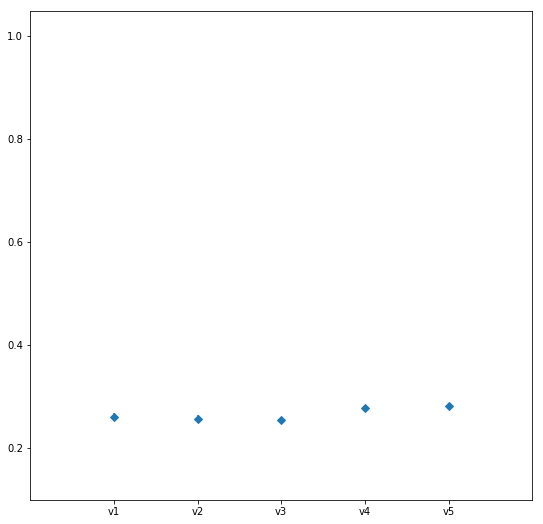

In [8]:
def create_decision_trees(X, y):
    '''Function to run all parts of DT creation and testing
    '''
    print("Decision Trees\n")

    # Make a list of trees
    trees = []
    #creates 5 different decision tree classifiers with different parameters and 
    #fits the data to them. See paper for parameter explanations
    dt = tree.DecisionTreeClassifier(criterion='entropy')
    trees.append(dt)
    dt = tree.DecisionTreeClassifier(criterion='gini')
    trees.append(dt)
    dt = tree.DecisionTreeClassifier(criterion='entropy', max_depth = 2)
    trees.append(dt)
    dt = tree.DecisionTreeClassifier(criterion='entropy', min_samples_leaf = 25)
    trees.append(dt)
    dt = tree.DecisionTreeClassifier(criterion='entropy', max_leaf_nodes = 50)
    trees.append(dt)
    
    return trees

trees = create_decision_trees(X, y)

confusionMatrix(X, y, trees[0])

# Compute cross validations for each model and print them
cvs = fiveFoldCVs(X, y, trees)
print("Confidence Intervals:")
for i in range(len(cvs)):
    print("v" + str(i+1) + ": ", cvs[i])
print()

# Compute p-values
getPValues(cvs)

# Create file for confidence intervals
cIPlot(cvs, 0.1)

### ANNs
After researching the neural net parameters, learnrate stood out to us as the most intriguing. We thus focused our trials on manipulating learnrate, providing two controls. We also explored more basic changes to the number of iterations and the structure of the neural net. The logic for each manipulation is as follows (parameters listed):
##### v1: (X, y, numIter=500)
Control. Default number of iterations has been raised to increase general
accuracy.
##### v2: (X, y, numIter=500, numNodes = 15, numLayers = 3)
For this manipulation, we chose to set the number of nodes to 15 and the number of hidden layers to 3. For most problems, a single hidden layer is sufficient, as the ANN weighting algorithms are complex enough that they do not need much to work with (see following versions), but we wanted to see what would happen when we set the number of layers at three, working with just the default other parameters. Theoretically, the increased complexity might increase accuracy, but it will also increase runtime.
##### v3: (X, y, numIter=500, solve = ‘sgd’)
Control (solve method). The default solver is ‘adam,’ which, according to
sklearn’s website, is “works pretty well on relatively large datasets (with thousands of training samples or more) in terms of both training time and validation score.” From brief research on stack exchange, the ‘adam’ solver is actually an adaptation of the more universal stochastic gradient descent (sgd); therefore, we thought it would be interesting to compare sklearn’s default solver to the primary default solver in the field. This exploration also provides the control for our investigations of learnrate, which all require the sgd solve method.
##### v4: (X, y, numIter=500, learnRate = 'adaptive', solve = 'sgd')
The learnrate of an artificial neural net determines how quickly the ANN deserts old generalizations of the dataset for new ones. For example, suppose the ANN encounters 10 board game samples that have average playtimes of 60 minutes and have a geek rating of 5 (the highest quantile). Then suppose it encountered an 11th board game that has an average playtime of 30 minutes, but also had a geek rating of 5. If the learnrate of the ANN is relatively high, it will assume that sometimes even games with playtimes lower than 60 minutes can be rated highly; if the learnrate is relatively low, it will assume that the 11th board game is an outlier, and that only board games with playtimes of 60 minutes can be rated highly. The ‘adaptive’ parameter keeps the learnrate of the ANN at a predetermined value throughout the course of training, unless the training loss stops decreasing. If training loss ever does begin to increase, the learning rate is divided by five. The ANN should get better and better at predicting as it trains, as it learns incrementally. If this does not happen, its training loss will increase, and it will begin to “learn faster.” Since a higher learning rate means longer train time, this is one way to find an reasonable learning rate for a given data set.
##### v5: (X, y, numIter=500, learnRate = 'invscaling', solve = 'sgd')
One other possible learnrate parameter is invscaling. Invscaling works by steadily
decreasing the learning rate (roughly following exponential decay) over a time interval t. Because invscaling allows the ANN to learn very quickly initially and then more slowly as time goes on, it can provide runtime advantages without compromising accuracy  but only with static datasets . If the dataset it dynamic, and new examples are being constantly added, invscaling is a poor choice because it will not allow the ANN to update any of its initial beliefs as quickly as it should. Since our dataset is static, we should be able to appreciate an increase in runtime without a loss of accuracy by utilizing invscaling.

ANNs

Score and Confusion Matrix to illustrate problem complexity
Score:  0.309
Confusion Matrix:
 [[ 94  17  21  18  57]
 [ 77  10  18  23  66]
 [ 61  13  23  18  81]
 [ 46  12  14  22 108]
 [ 14   1  10  16 160]]

Confidence Intervals:
v1:  [ 0.294  0.28   0.313  0.318  0.317]
v2:  [ 0.309  0.277  0.32   0.311  0.306]
v3:  [ 0.204  0.193  0.187  0.18   0.184]
v4:  [ 0.204  0.193  0.187  0.182  0.184]
v5:  [ 0.204  0.193  0.187  0.22   0.221]

The p-value for 1,2 is 0.968486746913

The p-value for 1,3 is 0.000462134240533

The p-value for 1,4 is 0.000434831908457

The p-value for 1,5 is 0.000138037239823

The p-value for 2,3 is 0.000234853420856

The p-value for 2,4 is 0.000221591583612

The p-value for 2,5 is 0.000404695283501

The p-value for 3,4 is 0.3739009663

The p-value for 3,5 is 0.178239554897

The p-value for 4,5 is 0.177858401051



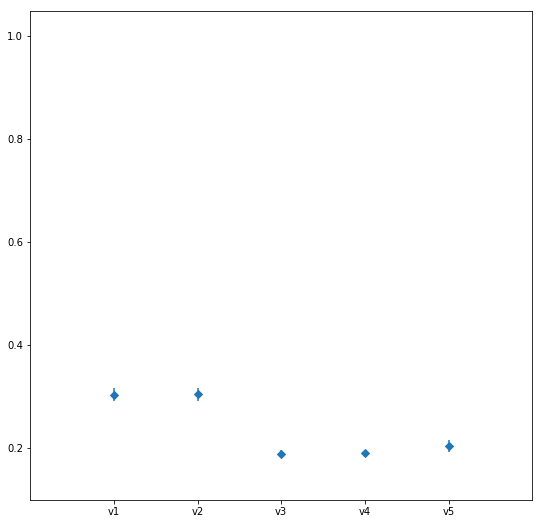

In [9]:
def makeMLP(X, y, numNodes=10, numLayers=3, numIter=200, learnRate='constant', solve='adam'):
    '''Make an ANN. Allow the number of nodes and the number of hidden layers
    and the maximum number of iterations to be set as parameters. 
    Returns the ANN.'''
    
    # Create a hidden layer tuple based on the parameters passed to the
    # function
    hiddenLayers = [numNodes for i in range(numLayers)]
    hiddenLayers = tuple(hiddenLayers)

    # Initialize ANN classifier using hiddenLayers tuple to set sizes
    ann = MLPClassifier(hidden_layer_sizes=hiddenLayers, 
                        activation='logistic',      # default is 'relu'
                        max_iter = numIter,         # default is 200
                        learning_rate = learnRate,
                        solver = solve,
                        random_state=0)             # seed
    return ann

def create_anns(X, y):
    print("ANNs\n")
    
    # Make a list of ANNs, each with a number of hidden nodes and number
    # of iterations specified in the lists "hNodes" and "maxIters" respectively
    # passed as a parameters
    anns = []

    #creates 5 artificial neural net models with 5 different sets of parameters. 
    #see paper for parameter explanations.
    ann = makeMLP(X, y, numIter = 500)
    anns.append(ann)
    ann = makeMLP(X, y, numIter = 500, numNodes = 15, numLayers = 3)
    anns.append(ann)
    ann = makeMLP(X, y, numIter = 500, solve = 'sgd')
    anns.append(ann)
    ann = makeMLP(X, y, numIter = 500, learnRate = 'adaptive', solve = 'sgd')
    anns.append(ann)
    ann = makeMLP(X, y, numIter = 500, learnRate = 'invscaling', solve = 'sgd')
    anns.append(ann)
    
    return anns

anns = create_anns(X, y)

confusionMatrix(X, y, anns[0])

# Compute cross validations for each model and print them
cvs = fiveFoldCVs(X, y, anns)
print("Confidence Intervals:")
for i in range(len(cvs)):
    print("v" + str(i+1) + ": ", cvs[i])
print()

# Compute p-values
getPValues(cvs)

# Create file for confidence intervals
cIPlot(cvs, 0.1)
print()

## Results
The maximum classification accuracy for all of our models and cross validations was 0.315, from v1 of our ANNs. The minimum classification accuracy was 0.18 from v3 of our ANNs. All of our classifiers have accuracies falling between this range of 0.18-0.315. Given the p-values for our decision trees, the differences between v1, v2, and v3 were not statistically significant, and the differences between v4 and v5 were also not statistically significant. However, the differences between these two groups of trees were statistically significant. Among our decision trees, v4 and v5 performed the best, and their superior performance compared to v1, v2, and v3 is statistically significant. This suggests that the parameters implemented here to reduce overfitting were somewhat effective. Similarly, given the p-values for our ANNs, the differences between v1 and v2 were not statistically significant, and the differences between v3, v4, and v5 were also not statistically significant. However, the differences between these two groups of ANNs were statistically significant. Among our ANNs, v1 and v2 performed the best, and their superior performance compared to v3, v4, and v5 is statistically significant. This suggests that the default solver for sklearn’s MLPclassifier is superior compared to sgd when applied to this dataset.